# Palacing Apples in Snake - Intro
###  

Some video-games use uniform random distribuition to generate their level content. This also happens in Snake, where the location of each apple is set by calling a random generator. Because of this some apples are much easier the catch than others, or we run into sitiations where the snake doesn't even have to change directions. We can see an exemple of this in the image below:

![alt text](jupyter_imgs/snake_bad_apple.png "Bad Apple")

After playing Snake for a little while (during a tutorial! I usually don't play snake for fun! :P) and having this situation happen to me a couple times I started to think about a way of choosing the location of the apple (we are going to call it placing an apple) in a smarter way by using a regression model. This model can then take into account the Snake's state (the snake's position and direction) to predict the location of the next apple. This way we avoid the situation like the one I metioned above, and also make the process of comparing the score more fair, once they are not affected by a random variable.

But this is not a conventional regression problem once there is no ground true. Each apple location is chosen randomly and therefore some apples have a good location and some others don't (By good location I mean that the apple was puted in a location that forces the player to take action). Therefore we need a way to select the good apples, so that our model can learn from them. 

For this we need to score each individual random apple location, and then use that score to select what were the best apple placements. To get to this score, we are going to use several metrics that measure the quality of a placement. Keep in mind that if we want to place the apple accordingly to the snake's state, these metrics should take this state into account. I will explain these metric in more detail later.

Now that we have a data set with the best apple placements, we still have the problem that for a particular snake's state observation there are several locations that might be good to place an apple. To solve this, we are going to use this select dateset to generate several apple locations. Because these apples are generated close to the original apple, the quality of these generated locations should be close to the original selected data set. Also we are going to filter out all the generated locations that have worse metrics than the original observation.

After this all that is left to do is to use cross_validation to select the best model for our data set, and then test this model in our test set.



### Contents:

Part 1: Creating a game log

Part 2: Placing apples!

0 - Opening the game log

0.1 - Vizualizing some observations

1 - Metrics to select the best apple placements

1.1 - Metric's Scores

2 - Filtering Metric's Scores to create a training set

2.1 - Generating more apples

3 - Features

4 - Tranning

4.1 - Testing

5 - Create a model with your apples!


# Part 1: Creating a game log

For the fisrt part we are going to create a game log. This game log will be a file where we write all the apple locations and the snake's state when this apple was placed. Since some of the variables, such as the snake's position or direction, are `list` type, I decided to use .tsv instead of .csv so that we can dump them directly as text without worrying about the commas that are present between values in a `list`. This .tsv will also have some other fields for the metrics that have to be captured during the game (`time_secs` and `moves_to_apple`), `time_secs` is the number of seconds since the game started and `moves_to_apple` is the number of moves a player needed to catch an apple.

This way this .tsv will contain the fields:

`status|time_secs|score|moves_to_apple|apple_pos|snake_pos|snake_dir`

During this part, one of the challenges was:

Considering a single apple, we have to save the snakes state when this apple is generated. But once we want to measure the number of moves a player took to catch this same apple, the snake state will be different at this point. We also need to save the snake state when the apple is placed in the same row as the moves it took to catch that apple. So to achive this we have to save the snake state when the apple is placed in a seprate varible, wait for the snake to catch the apple (to know how many moves it took) and then dump the saved snake state and `moves_to_apple` (or any other variable available during prediction time) in the game log file.



# Part 2: Placing apples!
###  
In this 2nd part we are going to use the data from our game log to create our metrics, select a dataset, train and test our models.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# Sklearn
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
# Helper funtions
from jupyter_utils.plots import plot_snake
from jupyter_utils.metrics import compute_distance, compute_all_metrics, get_n_highest_rows
from snake_game.features import position_norm, compute_all_feats
from snake_game.config import SCR_SZ

## 0 - Opening the game log
We start by opening the game log file with the apple placements 

In [2]:
from jupyter_utils.parser import parse_and_preprocess_game_log

df = parse_and_preprocess_game_log("game_log_1.tsv")

# Checking the types to make sure or parsing is working
print(df.dtypes)
# Quick look into the data
with pd.option_context('display.max_rows',10):
    display(df)

status             object
time_secs         float64
score               int64
moves_to_apple      int64
apple_pos          object
snake_pos          object
snake_dir          object
other              object
time_to_apple     float64
dtype: object


,status,time_secs,score,moves_to_apple,apple_pos,snake_pos,snake_dir,other,time_to_apple
0,start,0.000,0,0,[],[],[],{},0.000
1,apple,2.067,0,2,"[360, 130]","[[140, 280]]","[3, 0]",{},2.067
2,apple,4.282,0,2,"[100, 250]","[[380, 148]]","[0, -3]",{},2.215
3,apple,5.529,1,2,"[270, 240]","[[107, 220], [107, 187]]","[0, 3]",{},1.247
4,apple,7.432,2,3,"[190, 370]","[[248, 250], [242, 277], [209, 277]]","[0, -3]",{},1.903
...,...,...,...,...,...,...,...,...,...
1365,apple,94.875,41,2,"[390, 290]","[[18, 210], [18, 243], [18, 276], [18, 309], [...","[0, -3]",{},4.462
1366,apple,97.341,42,2,"[170, 300]","[[381, 261], [381, 228], [381, 195], [381, 162...","[0, 3]",{},2.466
1367,apple,102.096,43,5,"[410, 40]","[[147, 309], [147, 342], [147, 375], [165, 390...","[0, -3]",{},4.755
1368,apple,107.060,44,4,"[110, 200]","[[381, 18], [348, 18], [315, 18], [282, 18], [...","[3, 0]",{},4.964


### 0.1 - Vizualizing some observations
#####  
As a helper method, I created the function `plot_snake()` (`jupyter_utils.py`). This function can be used to check the snake and apple(s) position. 

It's quite useful as it allows you to visualize several placements at the same time. It helps you do simple debugging and experiment with the type of game scenarios you have in your training set. It also helps with feature engineering and to check the model's prediction.

We are also adding a column that represents the position of the previous apple. This column is used in the visualization and also to make sure our game logs are correct.

In [3]:
# The position of the previous apple can be obtained by just shifting the "apple_pos" column
df["prev_apple_pos"] = df.apple_pos.shift(1)

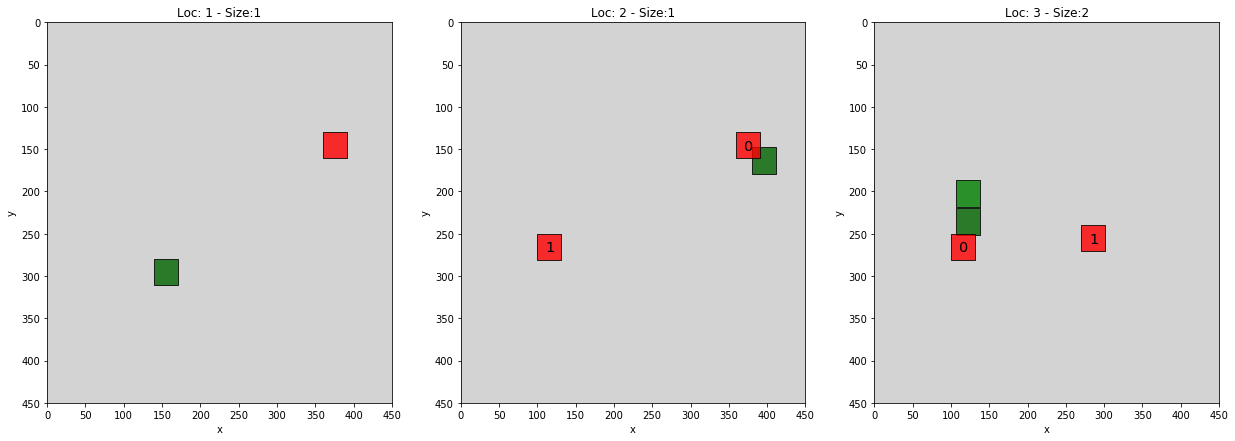

In [4]:
# Exemple on how to use plot_snake()
plot_snake(df.iloc[:4])

## 1 - Metrics to select the best apple placements
####  
As explained before, we need to design a metric to measure the quality of each apple location, in relation with the snake's state. We have to keep in mind that there are several criteria we can use for these metrics. The beahviour of our model will be influenced by the metrics you use, since these metrics will be used to select our training set. This way different metrics can be chosen to archive different game experiments.

When designing these metrics, take into account that simple metrics work better once it's easier for the model to indentify relations between the apple's location and the snake's state. Also you should have more than one metric, as different metrics might be useful in different stages of the game.

With this in mind let's think about some metrics that we can use:

   * `time_to_apple`: The time that it takes for the snake to go from one apple to the other. The longer it takes for the snake to get to an apple, the better than apple was placed. This is not necessarly always true, especially for the beggining of the game, but as the snake grows, the snake's body gets in the way of the apple, making you take longer for apples that were not in direct reach.
    
   * `moves_to_apple`: This is a pretty simple metric, the more moves you had to make to get the apple, the harder it was and therefore the better that apple was placed.

   * `apple_dist`: The disntace between the apple and the snake's mouth. This metric aims to penalize apples that were to close to the snake. Not all the apples that are close to the snake are bad, but we can detect those with other metrics.

   * `snake_dir_to_apple_angle`: The angles between the snake's direction and the apple. The higher this angle is the more moves the player will have to do, as the snake needs to change its direction.

![alt text](jupyter_imgs/snake_dir_apple_angle.png "Title")

   * `num_intersections_w_snake`: The number of times that a strait line from the apple to the snake's mouth intersects the snake's body. If there is an intersection, this mean that the sanke can not go directly towards the apple (as we can see in the image below), and therefore demands more moves, making it a harder to get the apple. In the example below it's 1.

![alt text](jupyter_imgs/snake_intersections.png "Title")

Below we will calculate these metrics.

In [5]:
metrics_df = df[df.status != 'start'].drop("other", axis=1).copy()
metrics_df = compute_all_metrics(metrics_df)
metrics_df.head()

,status,time_secs,score,moves_to_apple,apple_pos,snake_pos,snake_dir,time_to_apple,prev_apple_pos,apple_dist,snake_dir_to_apple_angle,num_intersections_w_snake,num_apple_sides_w_snake
1,apple,2.067,0,2,"[360, 130]","[[140, 280]]","[3, 0]",2.067,[],266.270539,34.286877,0.0,0
2,apple,4.282,0,2,"[100, 250]","[[380, 148]]","[0, -3]",2.215,"[360, 130]",298.000000,110.015960,0.0,0
3,apple,5.529,1,2,"[270, 240]","[[107, 220], [107, 187]]","[0, 3]",1.247,"[100, 250]",164.222410,83.004808,0.0,0
4,apple,7.432,2,3,"[190, 370]","[[248, 250], [242, 277], [209, 277]]","[0, -3]",1.903,"[270, 240]",133.281657,154.203974,1.0,0
5,apple,10.427,3,2,"[370, 10]","[[194, 340], [194, 307], [194, 274], [194, 241]]","[0, 3]",2.995,"[190, 370]",374.000000,151.927513,0.0,0


Now, let's take a look at the highest top 3 cases for each metric.

As we can see, for most of these cases the apple location was not an easy one for the player.

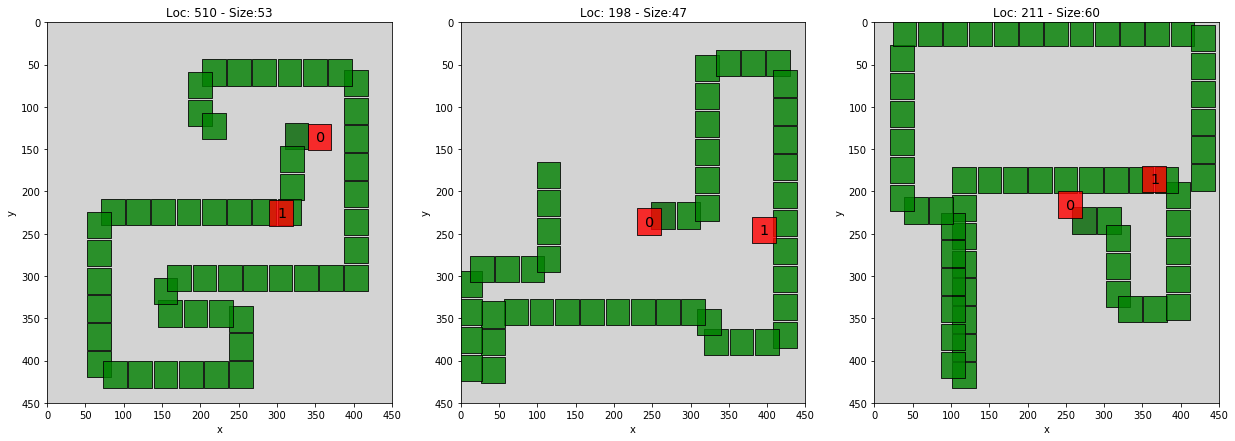

In [6]:
plot_snake(get_n_highest_rows(metrics_df, "time_to_apple"))

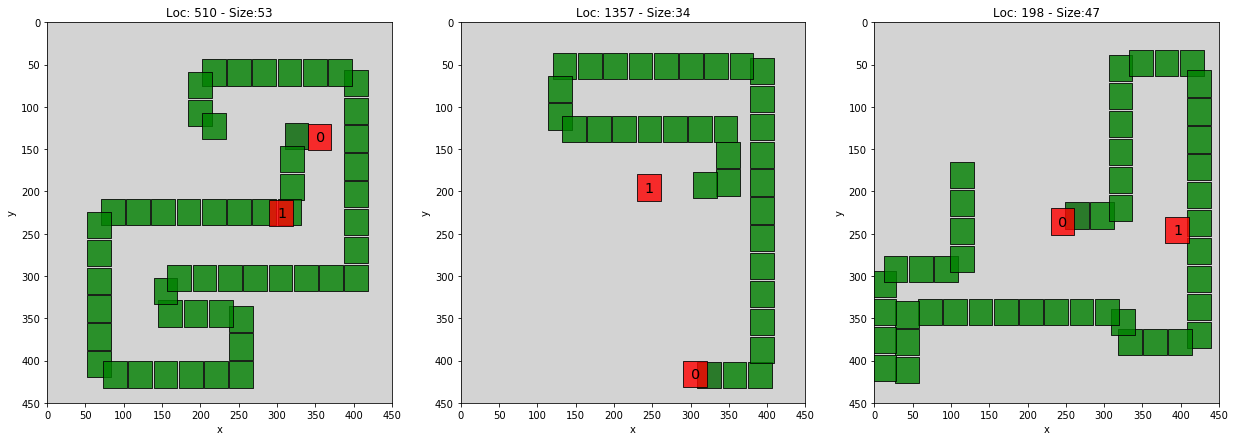

In [7]:
plot_snake(get_n_highest_rows(metrics_df, "moves_to_apple"))

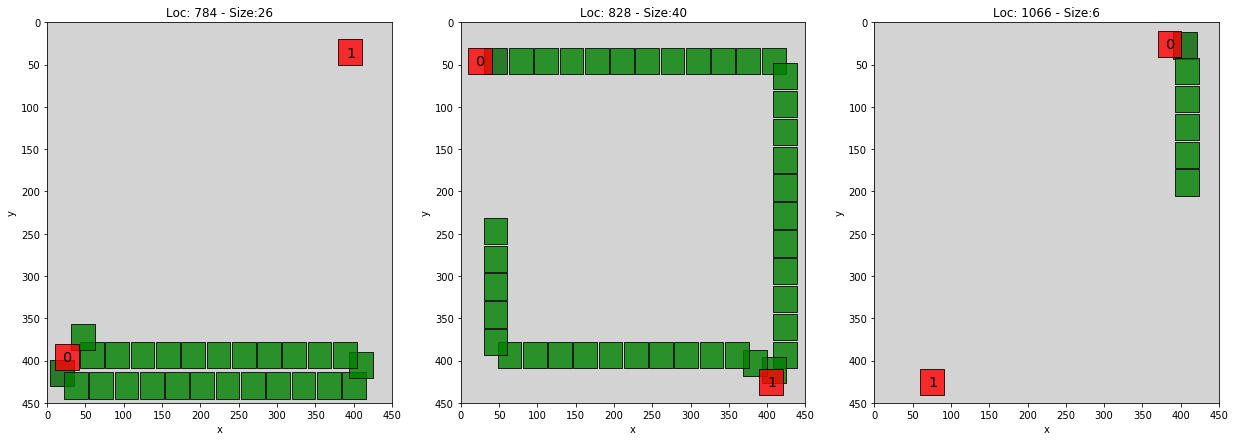

In [8]:
plot_snake(get_n_highest_rows(metrics_df, "apple_dist"))

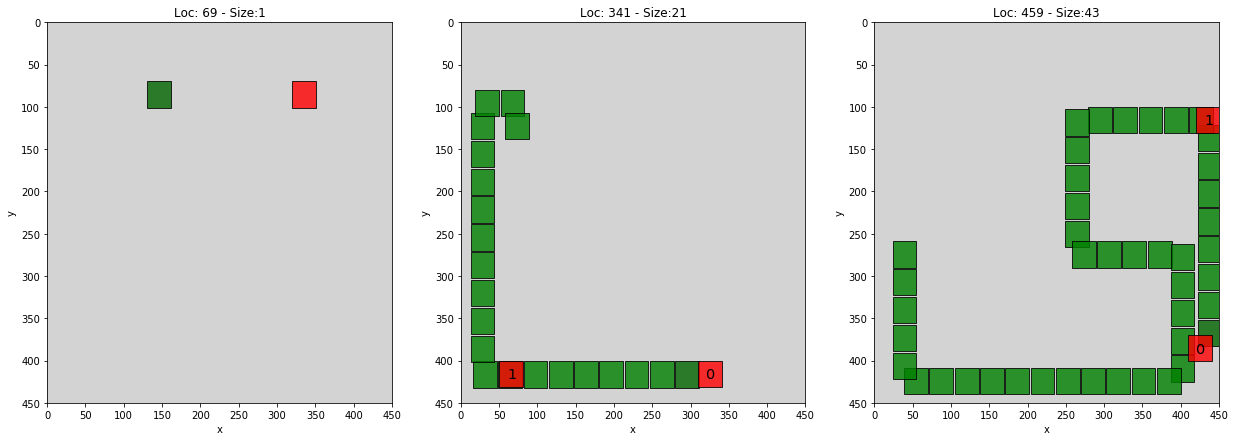

In [9]:
plot_snake(get_n_highest_rows(metrics_df, "snake_dir_to_apple_angle"))

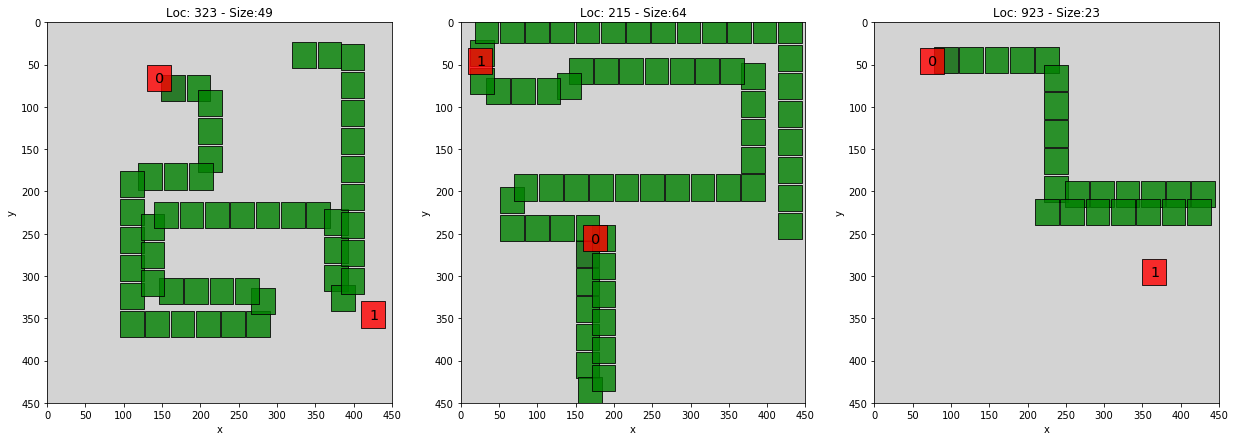

In [10]:
plot_snake(get_n_highest_rows(metrics_df, "num_intersections_w_snake"))

To make sure our metrics are correct let's take a look at their distributions.

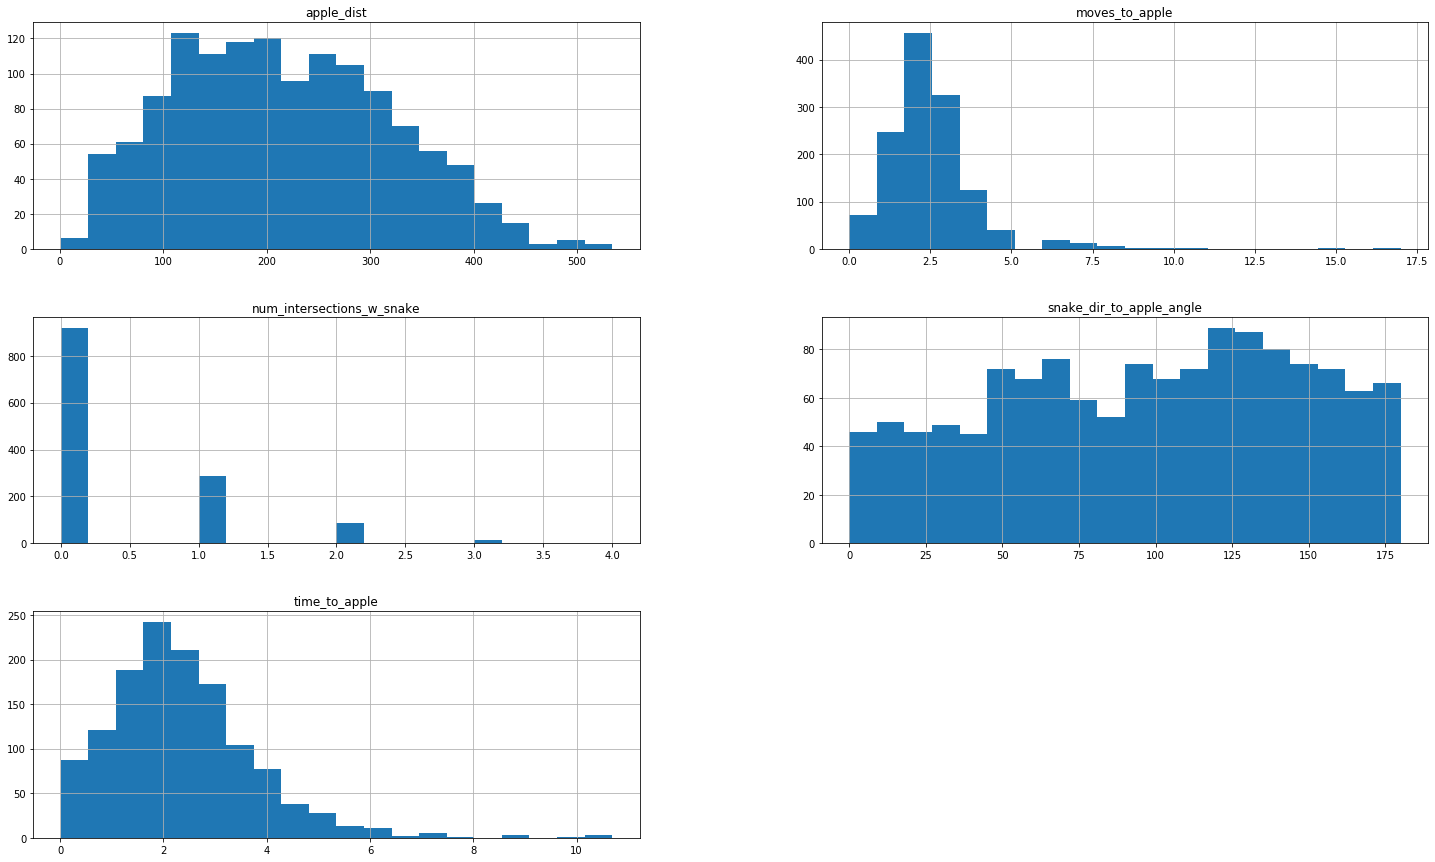

In [11]:
metrics_columns = ["moves_to_apple", "time_to_apple", 
                   "apple_dist","snake_dir_to_apple_angle", 
                   "num_intersections_w_snake"]
_=metrics_df[metrics_columns].hist(bins=20,figsize=(25,15))

### 1.1 - Metric's Scores
#####   
Now that we have several metrics, we need a single value score that allows us to select the best placements. This score can also be used to compare the performance between different models and the random process.

To compute the score we are going to calculate a weighted average of the metrics we defined. We can pick diferent weights depending on the desired beahviour we want for our model's predictions. But keep in mind that each metric has a different scale and shape and we are including all these different metrics in a single score. 

Therefore, we shouldn't average the value of the metric itself (ex: secs_to_Apple:2.3s) but the percentile. So in the end we are going to get the percentile of each observation per metric and then get the final score by averaging these percentiles. This way we remove the shape and scale of each metric and have more control over the weights in the final score.

In [12]:
metrics_columns

['moves_to_apple',
 'time_to_apple',
 'apple_dist',
 'snake_dir_to_apple_angle',
 'num_intersections_w_snake']

In [13]:
# Inplementation of the score funtion
#score_columns = ["moves_to_apple", "time_to_apple", "apple_dist", "snake_dir_to_apple_angle"]
score_weights = [1,1,1,1, 1]
def score_apples_placement(df, score_columns, score_weights):
    score_df = df[score_columns]

    #score_df = (score_df-score_df.min())/(score_df.max()-score_df.min())
    score_df = score_df.rank()/score_df.rank().max()

    score_df["apple_plc_score"] = np.average(score_df, axis=1, weights=score_weights)
    return score_df["apple_plc_score"]

# The columns that had a weight deferent than zero during the scoring
valid_filter_cols = [m for m, w in zip(metrics_columns, score_weights) if w != 0]
# Calculating the scores
metrics_df["apple_plc_score"] = score_apples_placement(metrics_df, metrics_columns, score_weights)

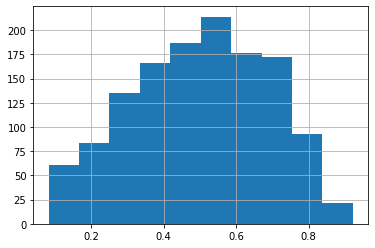

In [14]:
# The distribuition of our scores 
metrics_df["apple_plc_score"].hist()

# 2 - Filtering Metric's Scores to create a training set
###  
Now that we scored each apple we want to use these scores to create a training set with the best placements. Before that we are also going to select our test set, since the test set shouldn't be affected by this filtering.

In [15]:
# Pick the last 15 games
test_ds_start_idx = df[df.status == 'start'].iloc[-15].name

test_df = metrics_df.loc[test_ds_start_idx:].copy()
metrics_df = metrics_df.loc[:test_ds_start_idx]#.iloc[:-1]

In [16]:
# Once we used percentile for our scores, by selecting a value of
# 0.6 as a lower limit for our trainig set, we garanty that if one of the metrics is 1
# then the other is at least 0.1
selected_df = metrics_df[metrics_df["apple_plc_score"]  >=0.65]
selected_df.shape

(248, 14)

After selecting our training set we have to make sure that we have observations in all spectrums of the game score. Because, we need our model to be trained with data for all the levels (in this case score) of the game.
As we can see below on the plot from the right.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12efb23c8>,
      dtype=object)

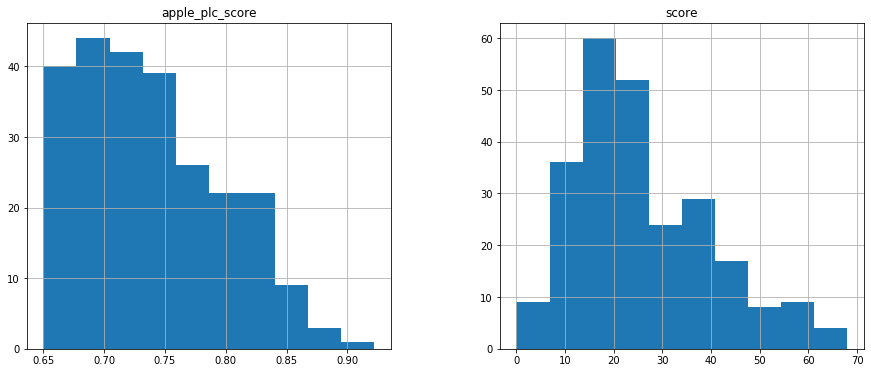

In [17]:
# We should have data points in all the score range
selected_df[["score","apple_plc_score"]].hist(figsize=(15,6))

### 2.1 - Generating more apples
#####  
For each snake's state, there is more than one possible option to place a good apple. So from a single placement we are going to randomly generate several placements that are close to the original placement. 
Also this helps our regressor to not over fit.
All the generated apple locations that have worse metric than the original observation are filtered, to make sure we don't generate observations that are worse than its original.

In [18]:
def generate_apples_from_row(row, n_try = 6):
    ap_pos = row.apple_pos
    rand_lim = [50,50]
    rand_lim_min = -np.minimum(ap_pos, np.array(rand_lim))
    rand_lim_max = np.minimum(np.array(SCR_SZ) - np.array(ap_pos), rand_lim)
    
    randa = np.stack((
        np.random.randint(rand_lim_min[0], rand_lim_max[0], size=(n_try,)),
        np.random.randint(rand_lim_min[1], rand_lim_max[1], size=(n_try,))
    ), axis=1)

    new_ap_pos = ap_pos+randa
    
    new_apples_df = pd.DataFrame(n_try*[row])
    new_apples_df["apple_pos"] = new_ap_pos.tolist()
    new_apples_df["apple_pos"] = new_apples_df["apple_pos"].apply(np.array)

    new_apples_df = compute_all_metrics(new_apples_df)
    selected_new_apples_bool = (new_apples_df[valid_filter_cols] >= row[valid_filter_cols]).all(axis=1)
    new_apples_df = new_apples_df[selected_new_apples_bool].reset_index()
    return new_apples_df

def generate_apples(df, n_tries_per_row = 6):
    generated_dfs = df.apply(lambda r: generate_apples_from_row(r, n_tries_per_row), axis=1)
    return pd.concat(generated_dfs.values, ignore_index=True)

In [19]:
# testing the function in a single row
# different runs will produnce different number of new obsevations
generate_apples(selected_df.iloc[:2])

,index,status,time_secs,score,moves_to_apple,apple_pos,snake_pos,snake_dir,time_to_apple,prev_apple_pos,apple_dist,snake_dir_to_apple_angle,num_intersections_w_snake,num_apple_sides_w_snake,apple_plc_score
0,6,apple,14.011,4,2,"[42, 402]","[[368, 28], [368, 61], [368, 94], [368, 127], ...","[0, -3]",3.584,"[370, 10]",496.137078,138.922713,0,0,0.67021
1,6,apple,14.011,4,2,"[38, 409]","[[368, 28], [368, 61], [368, 94], [368, 127], ...","[0, -3]",3.584,"[370, 10]",504.044641,139.102797,0,0,0.67021


# 3 - Features
###  
Once our model has to react to different states of the snake (possition and direction), we need features that reflect this.

For this use directly the snake direction (as dummies) and game score. Although we can't do the same with the snake's location, since the size of the snake keeps growing as the game progresses. So we need to normalize it to a constant size. To do this consider a line that starts in the snake's mouth and ends on the tail, the last square of the snake. To normalize the snake location to an array of size `N` we can simply sample this line in `N` points. In the exemple bellow `N=5`

![alt text](jupyter_imgs/snake_norm_loc.png "Title")

Besides these features I also tried to use the min, max and mean of the snake's location. 

Keep in mind that since these features have to be used during the game, we need to declare them outside this notebook, by defining them in the `snake_game/features.py` file. Also, because the feature are going to be computed during gameplay, we should keep performace in mind. For this I avoided using `pandas` and tried to use `numpy` as much as possible, even though in this particular case we are talking about snake!

In [20]:
feat_df = selected_df.copy()
# todo move to pre procc and solve game bug
feat_df.loc[(feat_df.score==0), "snake_dir"] =[[np.array([0,0])]]

feat_df = feat_df.apply(lambda r: pd.Series(compute_all_feats(r["snake_pos"], r["snake_dir"], r["score"], True)), axis=1)
feat_df["apple_pos"] = selected_df["apple_pos"]
#feat_df = feat_df.join(pd.get_dummies(feat_df["head_ang"].apply(int), prefix="head_ang"))

feat_df.head()

,norm_pos_0_x,norm_pos_0_y,norm_pos_1_x,norm_pos_1_y,norm_pos_2_x,norm_pos_2_y,norm_pos_3_x,norm_pos_3_y,norm_pos_4_x,norm_pos_4_y,...,snake_dir_D,snake_dir_U,min_x,min_y,max_x,max_y,avg_x,avg_y,game_score,apple_pos
5,194.0,340.0,194.00,315.25,194.0,290.5,194.00,265.75,194.0,241.0,...,1.0,0.0,194.0,241.0,194.0,340.0,194.000000,290.500000,3.0,"[370, 10]"
6,368.0,28.0,368.00,61.00,368.0,94.0,368.00,127.00,368.0,160.0,...,0.0,1.0,368.0,28.0,368.0,160.0,368.000000,94.000000,4.0,"[50, 380]"
19,416.0,178.0,356.75,259.00,302.0,173.5,241.25,94.00,257.0,34.0,...,0.0,1.0,209.0,34.0,416.0,259.0,308.333333,158.166667,17.0,"[280, 350]"
25,290.0,352.0,365.75,412.00,398.0,254.5,395.75,67.00,224.0,49.0,...,0.0,0.0,224.0,49.0,398.0,412.0,347.125000,235.875000,23.0,"[30, 80]"
27,233.0,250.0,125.75,151.00,36.5,85.0,242.75,85.00,338.0,196.0,...,1.0,0.0,11.0,85.0,338.0,250.0,180.615385,130.576923,25.0,"[130, 150]"


## 4 - Tranning
####  
In this final section we are going to to talk about some details we should pay attention to during cross validation and testing.

Since we are generating data that is based on other rows, we have to be careful with the way we generate new data.
 We have to make sure that there is no leaking between training and validation sets! For that we used sklearn `GridSearchCV`
 with costum folds. This way we start by using `KFold` in our selected dataset, then for each training fold we generate new data. Finally, this generated data is added to the initial training fold.
 
 This implementation can be seen below.

In [21]:
kf = KFold(n_splits=3)
train_df = selected_df.copy()
gen_folds = []
for train, test in kf.split(train_df):
    gen_df = generate_apples(train_df.iloc[train])
    
    prev_train_df_size = train_df.shape[0]
    train_df = train_df.append(gen_df.drop("index", axis=1), ignore_index=True, sort=True)
    
    new_train = np.array(tuple(train) + tuple(range(prev_train_df_size,train_df.shape[0])))
    gen_folds.append((new_train, test))

print("GENERATED", train_df.shape[0]-selected_df.shape[0], "ENTRIES FROM", selected_df.shape[0])

GENERATED 655 ENTRIES FROM 248


In [22]:
# Computing the features for the generated data
X = np.stack(train_df.apply(lambda r: compute_all_feats(r["snake_pos"], r["snake_dir"], r["score"]), axis=1).values)
y = np.stack(train_df.apple_pos.values)

X.shape, y.shape

((903, 21), (903, 2))

In [23]:
# picked Random Forest 
regr = RandomForestRegressor()
#regr = ExtraTreesRegressor()

To score our predictions we are going to use the strait line distance between the original apple location and the predicted one.

In [24]:
param_grid = {
    'n_estimators': [20],
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf':[1, 3,9],
    'max_features':['auto', 0.5, 0.9]
}
# Creating our scorer
scorer = metrics.make_scorer(lambda y, y_pred: compute_distance(y, y_pred).mean(), greater_is_better=False)

grid_clf = GridSearchCV(regr, param_grid, cv=gen_folds, scoring=scorer)
grid_clf.fit(X, y)#, sample_weight=samp_weights)

# Get best regressor
regr = grid_clf.best_estimator_

# Processing GridSearchCV results
results_df = pd.DataFrame(grid_clf.cv_results_['params'])
results_df["mean_test_score"] = grid_clf.cv_results_["mean_test_score"]
results_df.sort_values("mean_test_score", ascending=False)[:10]

/Users/filipe/.local/share/virtualenvs/snake_pydata-bZLAyaY7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,max_depth,max_features,min_samples_leaf,n_estimators,mean_test_score
14,10.0,0.5,9,20,-152.107293
22,20.0,0.5,3,20,-152.698702
32,NaN,0.5,9,20,-153.300954
28,NaN,auto,3,20,-153.549968
4,5.0,0.5,3,20,-153.747767
26,20.0,0.9,9,20,-153.836721
31,NaN,0.5,3,20,-154.021688
3,5.0,0.5,1,20,-154.268689
23,20.0,0.5,9,20,-154.302778
8,5.0,0.9,9,20,-154.489937


In [25]:
# Trainig error and final model
gen_df = generate_apples(selected_df)
total_train_df = selected_df.append(gen_df.drop("index", axis=1), ignore_index=True, sort=True)

X_total = np.stack(total_train_df.apply(lambda r: compute_all_feats(r["snake_pos"], r["snake_dir"], r["score"]), axis=1).values)
y_total = np.stack(total_train_df.apple_pos.values)
samp_weights_total = total_train_df["apple_plc_score"].values*10

# Prediction and avg error
regr.set_params(n_estimators=100)
regr.fit(X_total, y_total, sample_weight=samp_weights_total) 


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=9, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
# Training error
y_pred = regr.predict(X_total)

pred_dist = compute_distance(y_total,y_pred)

# We are have some overfit, once the train error is 2/3 lower than the test error
pred_dist.mean()

94.63433414795504

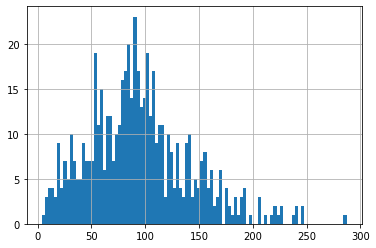

In [27]:
total_train_df["pred_apple_pos"] = np.vsplit(y_pred, y_pred.shape[0])
total_train_df["pred_apple_pos"]  = total_train_df["pred_apple_pos"].apply(lambda r:np.array(r[0]))
total_train_df["pred_dist"] = pred_dist
total_train_df["pred_dist"].hist(bins=100)

In [28]:
# Feature importance
# if scr_size is not the same, the bigger side is more important
features_importance_list = list(zip(feat_df.loc[:,:"game_score"].columns, regr.feature_importances_))
pd.DataFrame(features_importance_list).sort_values(1, ascending=False)[:10]

,0,1
0,norm_pos_0_x,0.115042
1,norm_pos_0_y,0.107559
12,snake_dir_D,0.102110
10,snake_dir_R,0.072882
11,snake_dir_L,0.068318
5,norm_pos_2_y,0.048683
13,snake_dir_U,0.046022
4,norm_pos_2_x,0.043108
18,avg_x,0.042093
3,norm_pos_1_y,0.040164


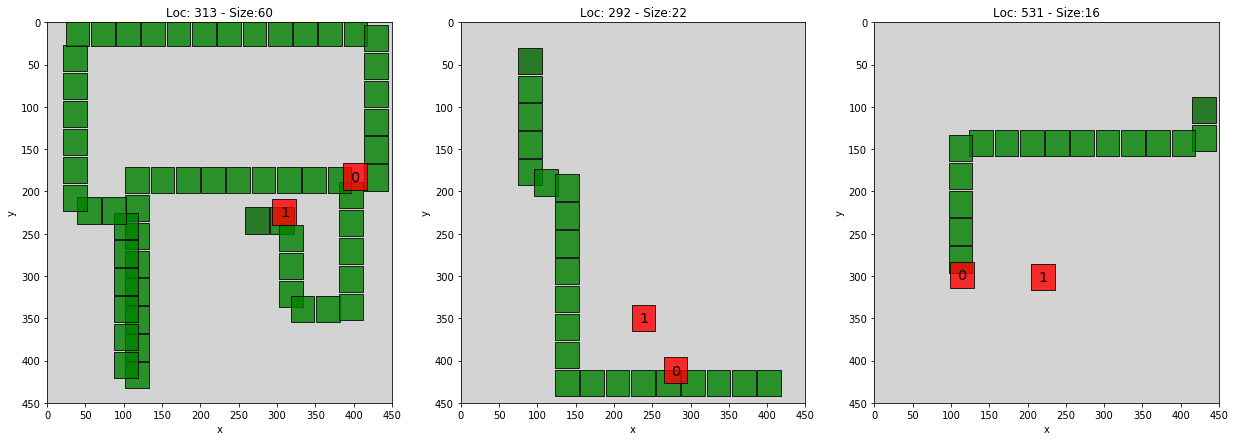

In [29]:
plot_snake(total_train_df.sample(3),apple_cols=["apple_pos","pred_apple_pos"])

In [30]:
# saving the model to be loaded in the game
model_name = 'regr.pkl'

with open(model_name, 'wb') as f:
    pickle.dump(regr, f)
# and later you can load it
with open(model_name, 'rb') as f:
    regr_ff = pickle.load(f)
# Making sure we load it and get the same training error
y_pred_ff = regr_ff.predict(X_total)
pred_dist_ff = compute_distance(y_total, y_pred_ff)
pred_dist_ff.mean()

94.63433414795504

## 4.1 - Testing
####  
To test our final prediction we shouldn't use the distance between the original apple location and the predicted one. In this cases we want to use the metrics that we defined to compare the random generator with our model, and check if our model has better average metrics than the random process.

In [31]:
test_df.head()

,status,time_secs,score,moves_to_apple,apple_pos,snake_pos,snake_dir,time_to_apple,prev_apple_pos,apple_dist,snake_dir_to_apple_angle,num_intersections_w_snake,num_apple_sides_w_snake,apple_plc_score
1036,apple,1.607,0,3,"[230, 390]","[[400, 300]]","[0, 3]",1.607,[],192.353841,62.102729,0.0,0,0.420593
1037,apple,2.263,8,1,"[180, 330]","[[235, 408], [259, 417], [292, 417], [325, 417...","[0, -3]",0.656,"[230, 390]",95.441081,35.188743,0.0,1,0.172580
1038,apple,4.292,12,2,"[230, 100]","[[199, 327], [232, 327], [235, 357], [235, 390...","[-3, 0]",2.029,"[180, 330]",229.106962,97.776429,0.0,1,0.451709
1039,apple,5.146,13,1,"[300, 170]","[[202, 90], [169, 90], [136, 90], [136, 123], ...","[3, 0]",0.854,"[230, 100]",126.506917,39.225674,0.0,1,0.199950
1040,apple,6.243,14,1,"[280, 350]","[[304, 141], [304, 108], [289, 90], [256, 90],...","[0, 3]",1.097,"[300, 170]",210.373477,6.550726,0.0,1,0.241541


In [32]:
# Computing features for the test set
X_test =np.stack(test_df.apply(lambda r: compute_all_feats(r["snake_pos"], r["snake_dir"], r["score"]), axis=1).values)
y_test = np.stack(test_df.apple_pos.values)
#samp_weights = test_df["apple_plc_score"].values
X_test.shape, y_test.shape

((320, 21), (320, 2))

In [33]:
y_pred_test = regr.predict(X_test)

pred_dist_test = compute_distance(y_test, y_pred_test)

test_df["pred_apple_pos"] = np.vsplit(y_pred_test, y_pred_test.shape[0])
test_df["pred_apple_pos"]  = test_df["pred_apple_pos"].apply(lambda r:np.array(r[0]))

In [34]:
pred_metrics_df = compute_all_metrics(test_df, apple_pos_col_name="pred_apple_pos")[metrics_columns]
orig_metrics_df = compute_all_metrics(test_df, apple_pos_col_name="apple_pos")[metrics_columns]

In [35]:
pred_metrics_df.mean()

moves_to_apple                 2.387500
time_to_apple                  2.277281
apple_dist                   204.875670
snake_dir_to_apple_angle     122.854570
num_intersections_w_snake      0.453125
dtype: float64

In [36]:
orig_metrics_df.mean()

moves_to_apple                 2.387500
time_to_apple                  2.277281
apple_dist                   213.964878
snake_dir_to_apple_angle      95.087138
num_intersections_w_snake      0.309375
dtype: float64

## 5 - Create a model with your apples!
####  
As a final challenge, I propose you to try to create a model with your own plays. For that, try to have at least 100 plays (apple catches), which, however, is still too few observations to train the model. You will have to decrease the limit of the metric's score and also increase the `n_tries` variable in the `generate_apples()` function.

Remeber to change the `get_apple_location_from_model` to `False` and the `file_name` in the `snake_game/config.py` file.